# **Preliminaries**


## Telco Customer Churn - Preliminaries
* The context: Predict behavior to retain customers,
and develop focused customer retention programs.
* Dataset taken from kaggle (https://www.kaggle.com/blastchar/telco-customer-churn)
* Each row represents a customer
* There are 7043 rows and 21 columns
* The “Churn” column is our target: Customers who left within the last month. Yes (26.5%), No (73.5%)

The data set includes information about:
* *Services that each customer has signed up for* – phone, multiple lines, internet, etc.
* *Customer account information* – how long they’ve been a customer, contract, payment method, charges, etc.
* *Demographic info about customers* – gender, age range, and if they have partners and dependents.

### List of features:
* customerID - like "7590-VHVEG" (categorical/string)
* gender - categorical - Male (50.5%), Female (49.5%)
* SeniorCitizen - boolean - 0 (84%), 1 (16%)
* Partner, Dependents, PhoneService, PaperlessBilling - boolean - Yes / No
* MultipleLines 
  - Yes / No / No phone service
* InternetService - Fiber optic / DSL / No
* OnlineSecurity, OnlineBackup, DeviceProtection,
  TechSupport, StreamingTV, StreamingMovies
 - Yes / No / No internet service
* Contract - Month-to-month, One year, Two year
* PaymentMethod - Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)
* tenure - numeric - Number of **months** the customer has stayed with the company:
  **mean: 32.37 (~2 years 8 months), min: 0, max: 72 (6 years), zeros: 11 (0.2%)**
* MonthlyCharges - numeric - **mean: 64.76, min: 18.25, max: 118.75**
* TotalCharges - string - converted to numeric - **mean: 2283, min: 18.8, max: 8684.8** (in 11 rows the value was space (" "), so we converted it to NaN and then imputed using mean value). 

## Install packages

In [17]:
# LUX: A Python API for Intelligent Visual Discovery (https://github.com/lux-org/lux)
# https://lux-api.readthedocs.io/en/latest/
#!pip install lux-api 

In [18]:
# Pandas Profiling Report
#!pip install pandas-profiling==2.7.1

In [19]:
# for TargetEncoder
#!pip install category_encoders

In [20]:
# for SHAP values (https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)
#!pip install shap

## Import Statements

In [21]:
# LUX
#import lux
#from lux.vis.Vis import Vis
#from lux.vis.VisList import VisList
#from google.colab import output
#output.enable_custom_widget_manager()

In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.cluster import KMeans 

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN

# Tensorflow is used for multiple tasks but has a particular focus on the training
# and inference of deep neural networks and Keras acts as an interface for the TensorFlow library.
import tensorflow as tf
from tensorflow import keras

from collections import Counter

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

pd.set_option('display.max_columns', None)

#constants
random_state = 42
plotColor = ['b','g','r','m','c', 'y']
markers = ['+','o','*','^','v','>','<']

#set up
sns.set(style='whitegrid')
%matplotlib inline

def csv_drive_path_generator(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path

 

In [23]:
def Generate_bar_graph(x, y, x_title, y_title, chart_title,color=plotColor):
    """ Based on x and y value, generate bar graph """
    
    fig, ax = plt.subplots()
    ax.bar(range(len(x))
       , y
       , width = 0.75
       , color=color
        , alpha = 0.6) 

    # stopping alphabetical sorting of graph
    plt.xticks(range(len(x)),x)
    plt.title(chart_title, fontsize=14)
    plt.xlabel(x_title,fontsize=13)
    plt.ylabel(y_title,fontsize=13)
    plt.grid(b=False)
    plt.yticks(fontsize=0)
    plt.ylim(top=1)

    
    # Visible x - axis line
    for spine in plt.gca().spines.values():
        spine.set_visible(False) if spine.spine_type != 'bottom' else spine.set_visible(True)
    
    # Display label for each plot
    for i,v in (enumerate(y)):
        ax.text(i
                ,v+0.05
                ,str(round((v*100),2))+'%'
                ,fontsize=13
                ,ha='center')
    
    plt.show()

## Read the Data

In [24]:
path = csv_drive_path_generator('https://drive.google.com/file/d/1za8Il7Bf7j_3_1MVCUapJ4vIYZEA_BHw/view?usp=sharing')
df = pd.read_csv(path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [25]:
type(df)

pandas.core.frame.DataFrame

In [26]:
print(f"The data frame has {df.shape[0]} rows and {df.shape[1]} columns.")

The data frame has 7043 rows and 21 columns.


# **EDA (Exploratory Data Analysis)**

## **LUX: A Python API for Intelligent Visual Discovery**

In [27]:
# LUX
# df.intent = ["tenure","MonthlyCharges"]
# df

In [28]:
# LUX
# Vis(["tenure"], df)

In [29]:
# LUX
# VisList(["Churn","?"],df)

In [30]:
# LUX
# VisList(["tenure","?"],df)

In [31]:
# LUX
# VisList(["MonthlyCharges","?"],df)

In [32]:
# LUX
#df.recommendation

## **Preliminary Analysis**

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


info() method shows us that 'TotalCharges' column is 'object' (expected to be numeric like monthly charges)

In [34]:
#numerical variables
num_features = list(df.select_dtypes(include=['int64','float64']))

#categorical variables
cat_features = list(df.select_dtypes(include='O'))
cat_features.remove('Churn')

print(f'Categorical features: {cat_features}')
print(f'Numeric features: {num_features}')
print("Target: ['Churn']")

Categorical features: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Target: ['Churn']


In [35]:
# value_counts of the categorical columns
for feature in cat_features:
    print(df[feature].value_counts(normalize=True), "\n")

print("-" * 30)
print(df.Churn.value_counts(normalize=True))

8063-GBATB    0.000142
6823-SIDFQ    0.000142
0628-CNQRM    0.000142
8670-ERCJH    0.000142
3704-IEAXF    0.000142
                ...   
3739-YBWAB    0.000142
3930-ZGWVE    0.000142
7952-OBOYL    0.000142
5092-STPKP    0.000142
2606-PKWJB    0.000142
Name: customerID, Length: 7043, dtype: float64 

Male      0.504756
Female    0.495244
Name: gender, dtype: float64 

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64 

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64 

Yes    0.903166
No     0.096834
Name: PhoneService, dtype: float64 

No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: MultipleLines, dtype: float64 

Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: InternetService, dtype: float64 

No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: OnlineSecurity, dtype: float64 

No                     0.438450
Yes                    0.

Pandas Profiling Report

In [36]:
# from pandas_profiling import ProfileReport
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

Report Summary
* 11 rows with " " in 'TotalCharges' column
* Otherwise - No missing cells 
* No Duplicate Rows

In [37]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,8063-GBATB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043,NaN,NaN,NaN,0.162147,0.368612,0,0,0,0,1
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043,NaN,NaN,NaN,32.3711,24.5595,0,9,29,55,72
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking for Duplicates

In [38]:
#duplicate value check
df.duplicated().any()

False

Checking Unique Values

In [39]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Checking for Missing Values




In [40]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Looks like no missing values

## **Handling Missing values**

Covert TotalCharges to numeric - invalid parsing will be set as NaN.

In [41]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

Checking for missing values again

In [42]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

There are 11 rows with no data in TotalCharges (also identified in Pandas profilng report)

In [43]:
df.loc[df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [44]:
df.loc[(df['tenure'] == 0)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


The 11 rows with no data in TotalCharges are the same grooup with tenure=0. 
These are new customers that have not yet completed one month. 
Have not yet paid a monthly bill.
None of these have churned.
Our decision - drop these 11 rows.


Dropping customers no total charges (and also the only rows with tenure=0) 

In [45]:
# Use this line to drop these these 11 rows
df.drop(df[df['tenure'] == 0].index, inplace=True)

## **Plotting Original Data**

Text(0.5, 1.0, 'Churn')

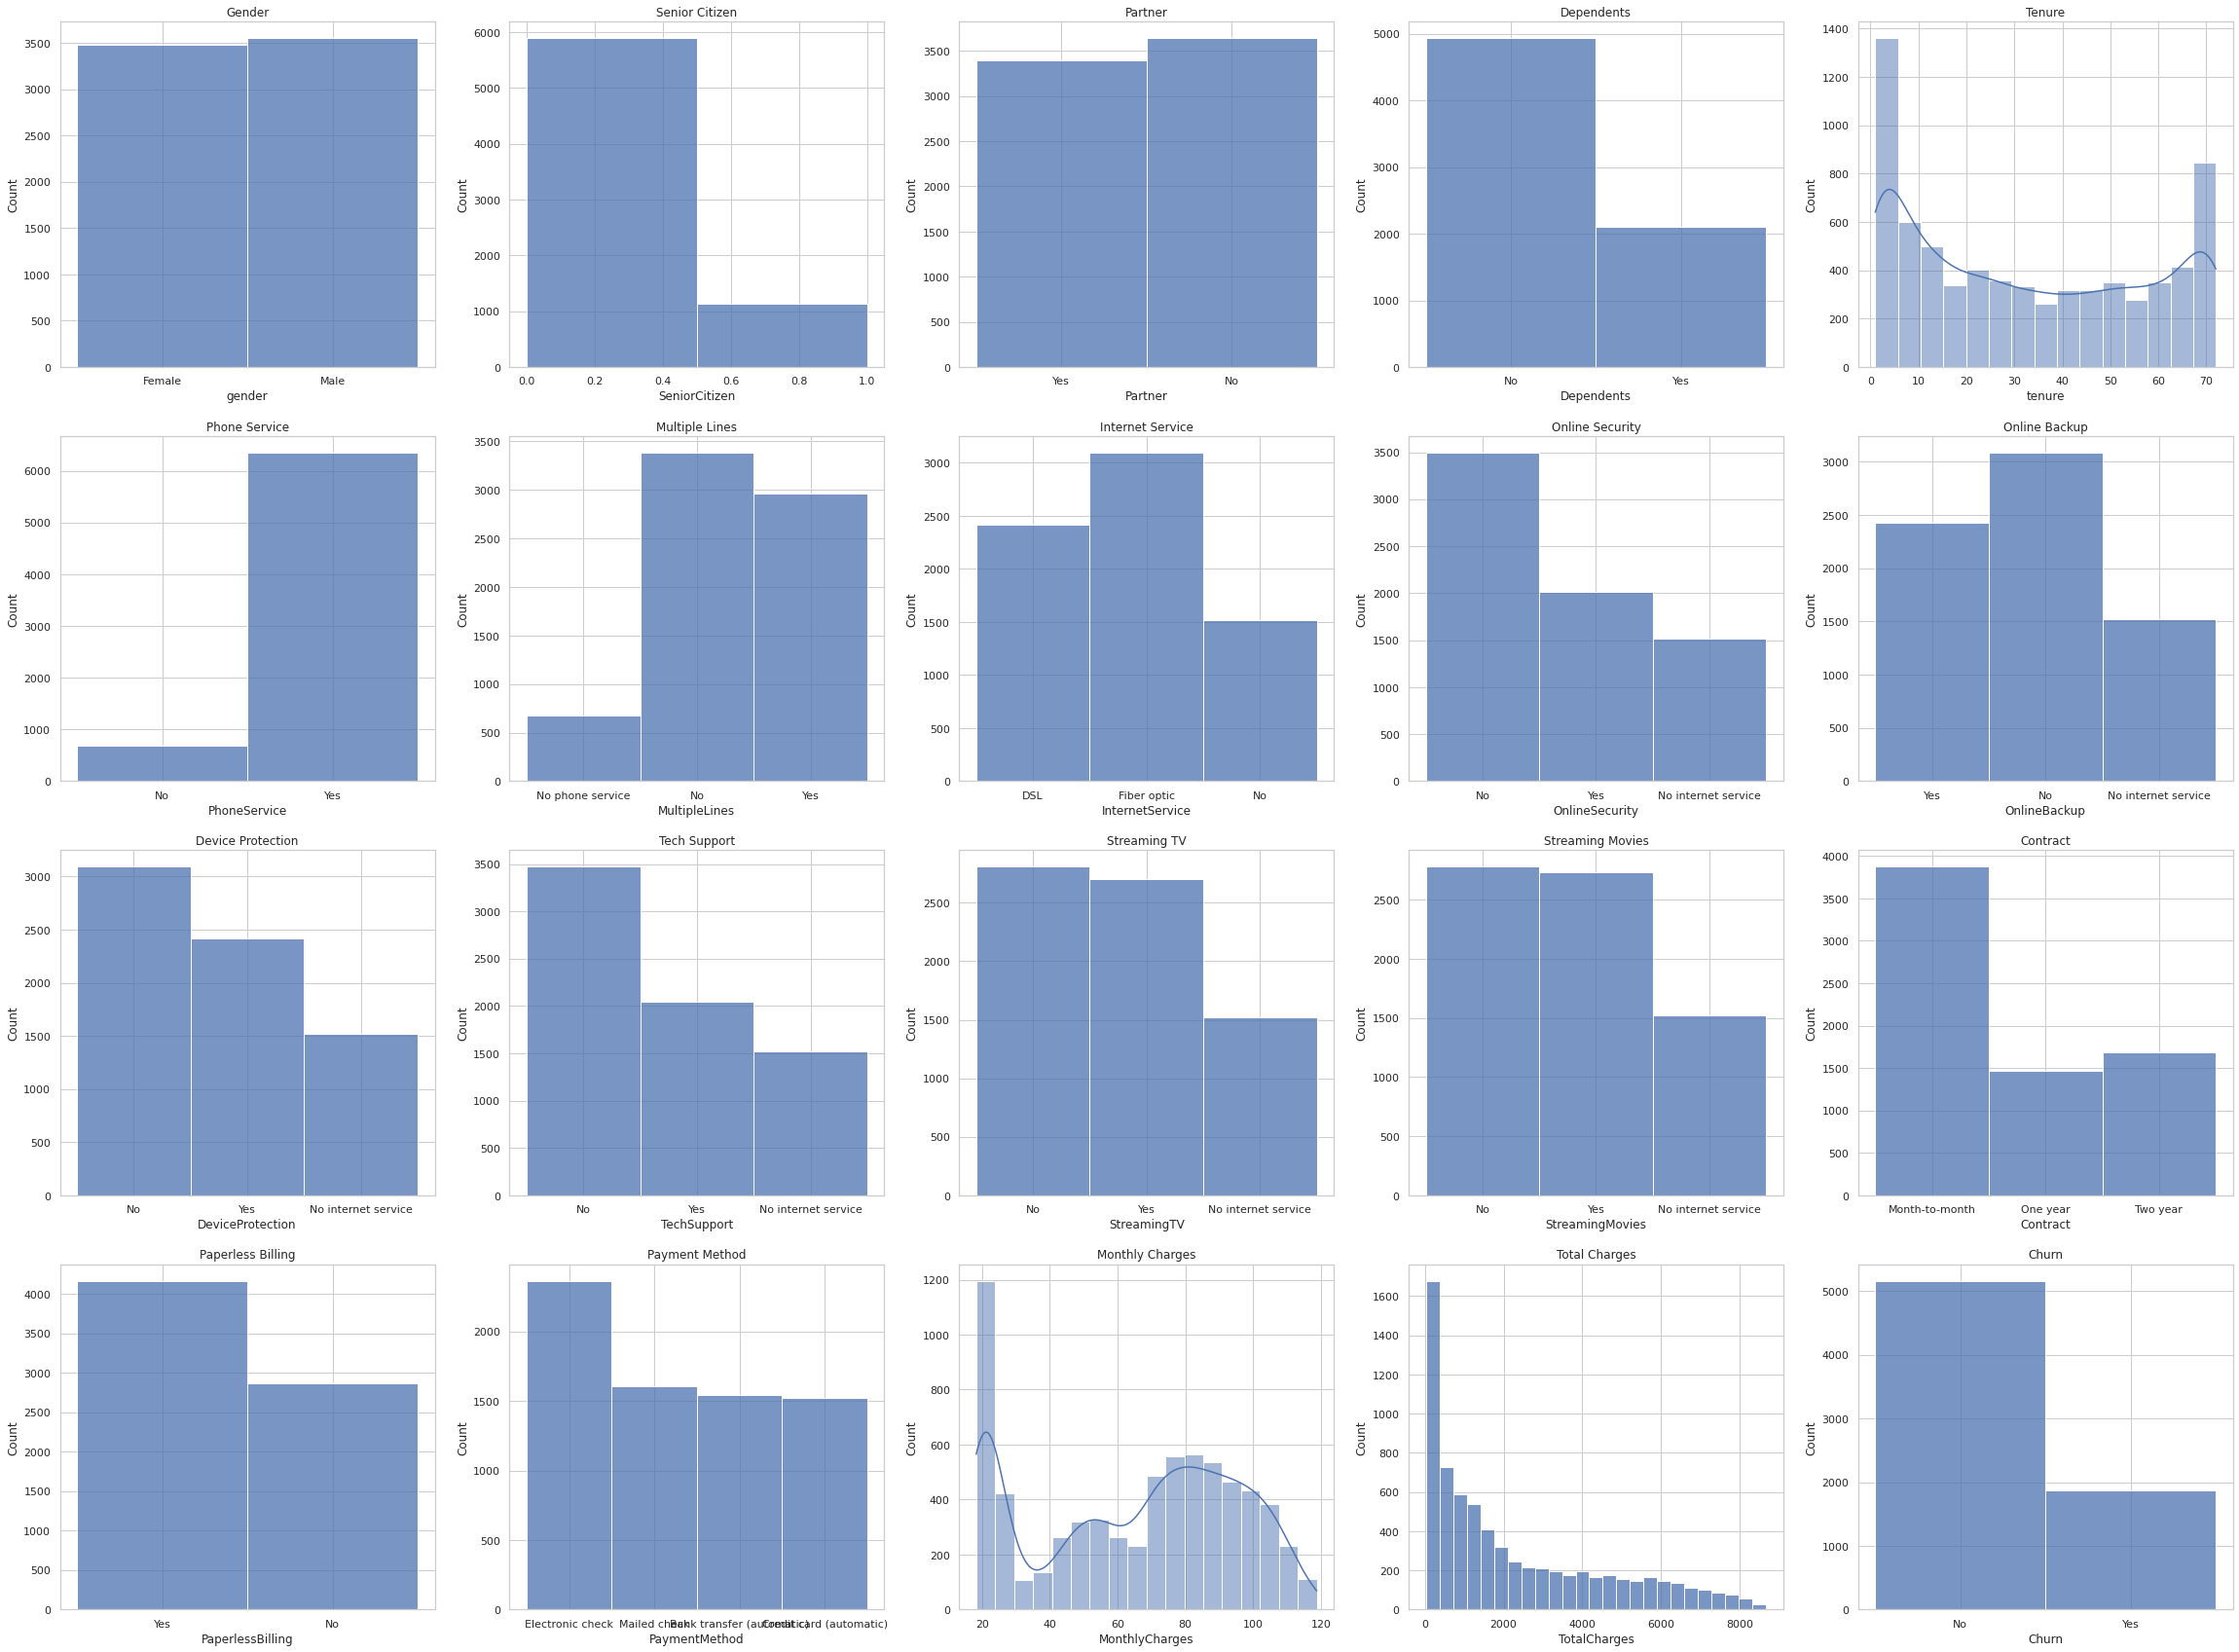

In [46]:
fig,ax = plt.subplots(4,5,figsize=(40,30))
sns.histplot(data=df, x="gender", bins=2, ax=ax[0,0]).set_title('Gender')
sns.histplot(data=df, x="SeniorCitizen", bins=2, ax=ax[0,1]).set_title('Senior Citizen')
sns.histplot(data=df, x="Partner",bins=2, ax=ax[0,2]).set_title('Partner')
sns.histplot(data=df, x="Dependents",bins=2,ax=ax[0,3]).set_title('Dependents')
sns.histplot(data=df, x="tenure", kde=True,ax=ax[0,4]).set_title('Tenure')
sns.histplot(data=df, x="PhoneService", bins=2, ax=ax[1,0]).set_title('Phone Service')
sns.histplot(data=df, x="MultipleLines",bins=3, ax=ax[1,1]).set_title('Multiple Lines')
sns.histplot(data=df, x="InternetService",bins=3, ax=ax[1,2]).set_title('Internet Service')
sns.histplot(data=df, x="OnlineSecurity",bins=3, ax=ax[1,3]).set_title('Online Security')
sns.histplot(data=df, x="OnlineBackup",bins=3, ax=ax[1,4]).set_title('Online Backup')
sns.histplot(data=df, x="DeviceProtection",bins=3, ax=ax[2,0]).set_title('Device Protection')
sns.histplot(data=df, x="TechSupport",bins=3, ax=ax[2,1]).set_title('Tech Support')
sns.histplot(data=df, x="StreamingTV",bins=3, ax=ax[2,2]).set_title('Streaming TV')
sns.histplot(data=df, x="StreamingMovies",bins=3, ax=ax[2,3]).set_title('Streaming Movies')
sns.histplot(data=df, x="Contract",bins=3, ax=ax[2,4]).set_title('Contract')
sns.histplot(data=df, x="PaperlessBilling",bins=2, ax=ax[3,0]).set_title('Paperless Billing')
sns.histplot(data=df, x="PaymentMethod",bins=4, ax=ax[3,1]).set_title('Payment Method')
sns.histplot(data=df, x="MonthlyCharges", kde=True,ax=ax[3,2]).set_title('Monthly Charges')
sns.histplot(data=df, x="TotalCharges", ax=ax[3,3]).set_title('Total Charges')
sns.histplot(data=df, x="Churn",bins=2,ax=ax[3,4]).set_title('Churn')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



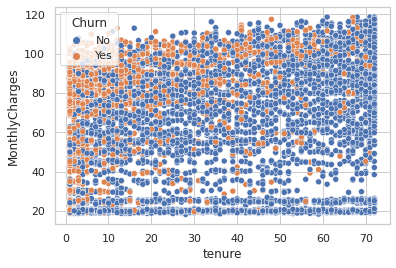

In [47]:
# Graph of churn as a function of tenure and monthly charges
#sns.set(rc = {'figure.figsize':(20,8)})
sns.scatterplot(df['tenure'], df['MonthlyCharges'], data=df, hue=df['Churn'])
plt.show()

Analyzing Churn by tenure

In [48]:
# Keeping both yes/no and 1/0 - for different uses - will drop one later after EDA
df['ChurnBinary']=df.Churn
df['ChurnBinary'] = df['ChurnBinary'].replace(['Yes','No'],[1,0])

In [49]:
churnbytenure=df.groupby('tenure')['ChurnBinary'].sum()
customersbytenure=df.groupby('tenure')['tenure'].count()
customersretained=customersbytenure-churnbytenure
churnratebytenure=churnbytenure/customersbytenure*100
data3 = {'Number Customers': customersbytenure, 'Churned Customers': churnbytenure,'Retained Customers':customersretained, '% Churn':round(churnratebytenure,2) }
churnbytenurepercentage=pd.DataFrame(data3)
churnbytenurepercentage

,Number Customers,Churned Customers,Retained Customers,% Churn
tenure,,,,
1,613,380,233,61.99
2,238,123,115,51.68
3,200,94,106,47.00
4,176,83,93,47.16
5,133,64,69,48.12
...,...,...,...,...
68,100,9,91,9.00
69,95,8,87,8.42
70,119,11,108,9.24


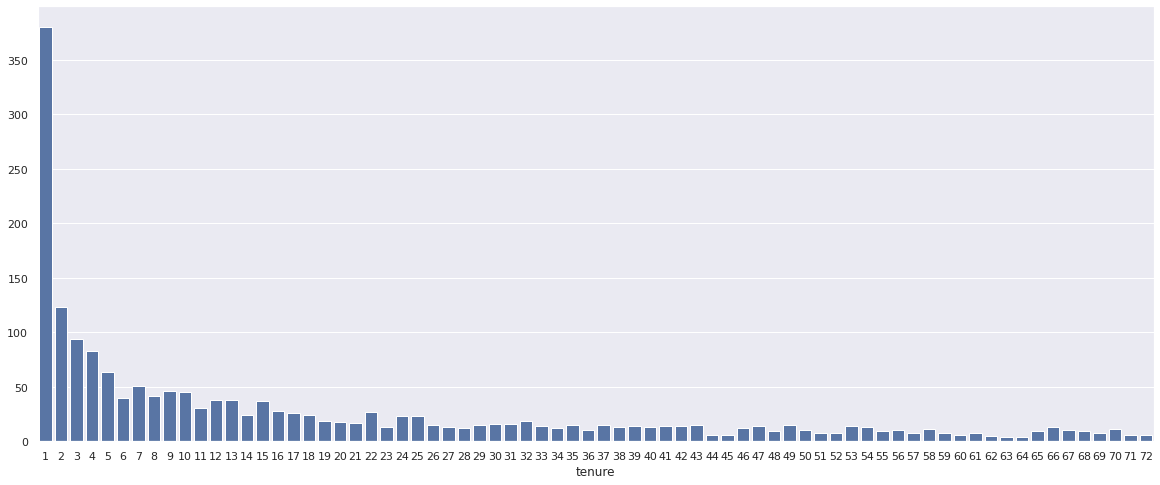

In [50]:
sns.set(rc = {'figure.figsize':(20,8)})
sns.barplot(x=churnbytenurepercentage.index, y=churnbytenurepercentage['Churned Customers'].values, color='b');

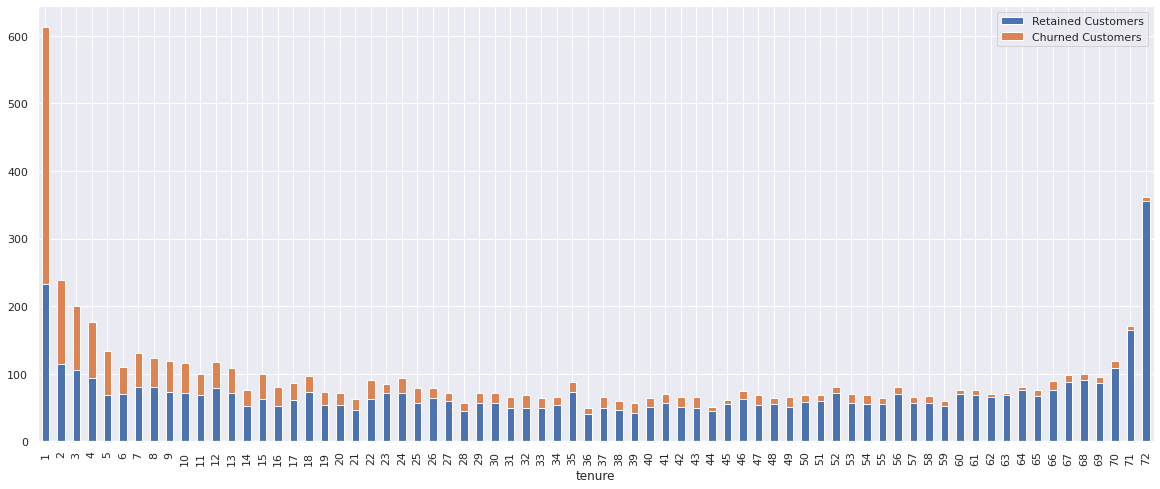

In [51]:
axis = churnbytenurepercentage[["Retained Customers", "Churned Customers"]].plot(kind="bar", stacked=True)
fig = axis.get_figure()

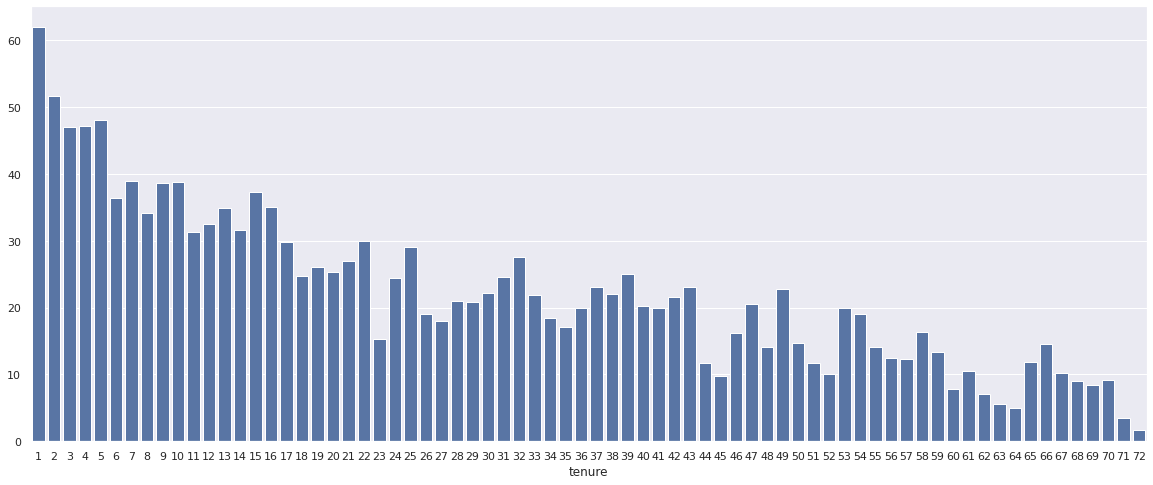

In [52]:
sns.set(rc = {'figure.figsize':(20,8)})
sns.barplot(x=churnbytenurepercentage.index, y=churnbytenurepercentage['% Churn'].values, color='b');

# **Feature Engineering**

### Binning continuous features to categorical features

Adding monthly charges categories

In [53]:
df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [55]:
#add a new category column next to the MonthlyCharges group. 
category = pd.cut(df.MonthlyCharges,bins=[0,35,90,200],labels=['Low Monthly Charges','Medium Monthly Charges','High Monthly Charges'])
df.insert(19,'MonthlyChargesCategory',category)

In [56]:
df['MonthlyChargesCategory'].value_counts(normalize=True)

Medium Monthly Charges    0.506826
High Monthly Charges      0.247298
Low Monthly Charges       0.245876
Name: MonthlyChargesCategory, dtype: float64

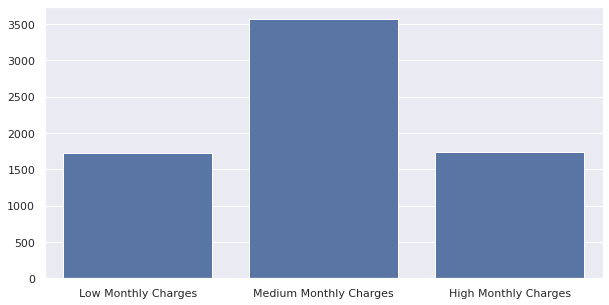

In [57]:
cluster_distrib = df['MonthlyChargesCategory'].value_counts()
sns.set(rc = {'figure.figsize':(10,5)})
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b')

Adding tenure categories

In [58]:
df['tenure'].describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [59]:
category = pd.cut(df.tenure,bins=[0,12,36,360],labels=['New Customer','Medium Term Customer','Long Term Customer'])
df.insert(6,'TenureCategory',category)

In [60]:
df['TenureCategory'].value_counts(normalize=True)

Long Term Customer      0.426763
New Customer            0.309300
Medium Term Customer    0.263936
Name: TenureCategory, dtype: float64

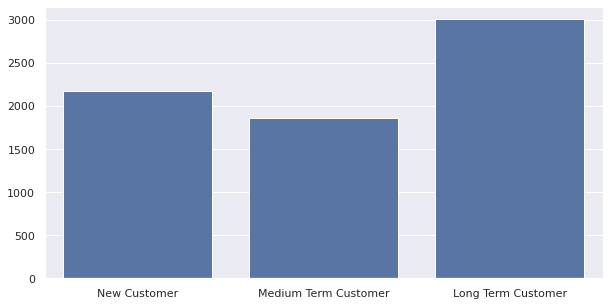

In [61]:
cluster_distrib = df['TenureCategory'].value_counts()
sns.set(rc = {'figure.figsize':(10,5)})
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   customerID              7032 non-null   object  
 1   gender                  7032 non-null   object  
 2   SeniorCitizen           7032 non-null   int64   
 3   Partner                 7032 non-null   object  
 4   Dependents              7032 non-null   object  
 5   tenure                  7032 non-null   int64   
 6   TenureCategory          7032 non-null   category
 7   PhoneService            7032 non-null   object  
 8   MultipleLines           7032 non-null   object  
 9   InternetService         7032 non-null   object  
 10  OnlineSecurity          7032 non-null   object  
 11  OnlineBackup            7032 non-null   object  
 12  DeviceProtection        7032 non-null   object  
 13  TechSupport             7032 non-null   object  
 14  StreamingTV             

### New columns 

1. "Has Internet Service" - "Yes" if customer has either DSL or Fiber Internet service. "No" if customer does not have Internet service at all.

2. "Has Only Phone Service" - "Yes" if customer has phone service and no Internet service.

3. "Has Only Internet Service" - "Yes" if customer has Interet service (Fiber or DSL) and no phone service.

4. "Has Both Phone and Internet Service" - "Yes" if customer both Interet service (Fiber or DSL) and phone service.

5. "Has Only Basic Internet Service" - "Yes" if customer has Internet service without any additional Internet services (Tech support, Online Backup, Streaming TV, etc.).

6. "Has Additional Internet Service" - "Yes" if customer has at least one of the 6 optional Internet services provided (Tech support, Online Backup, Streaming TV, etc.)

7. "Number Additional Services" - number of optional Internet service a customer has (0-6).


In [63]:
# New feature - has or does not have Internet service (DSL or Fiber doesn't matter)
df['HasInternetService']='No'
df.loc[df['InternetService'] == 'DSL', 'HasInternetService'] = 'Yes'
df.loc[df['InternetService'] == 'Fiber optic', 'HasInternetService'] = 'Yes'

In [64]:
# Checking if someone has an "additioal Internet service without basic Internet service"
a=len(df.loc[(df['HasInternetService'] == 'No') & (df['OnlineSecurity'] == 'Yes')])
b=len(df.loc[(df['HasInternetService'] == 'No') & (df['OnlineBackup'] == 'Yes')])
c=len(df.loc[(df['HasInternetService'] == 'No') & (df['TechSupport'] == 'Yes')])
d=len(df.loc[(df['HasInternetService'] == 'No') & (df['DeviceProtection'] == 'Yes')])
e=len(df.loc[(df['HasInternetService'] == 'No') & (df['StreamingTV'] == 'Yes')])
f=len(df.loc[(df['HasInternetService'] == 'No') & (df['StreamingMovies'] == 'Yes')])
print(a+b+c+d+e+f)
# No rows that have an "additional Internet service" without basic Internet service

0


In [65]:
#  New feature - has only phone service
df['HasOnlyPhoneService']='No'
df.loc[(df['HasInternetService'] == 'No') & (df['PhoneService'] == 'Yes'), 'HasOnlyPhoneService'] = 'Yes'
#df.loc[df['HasOnlyPhoneService'] == 'Yes']

In [66]:
#  New feature - has only Internet service
df['HasOnlyInternetService']='No'
df.loc[(df['HasInternetService'] == 'Yes') & (df['PhoneService'] == 'No'), 'HasOnlyInternetService'] = 'Yes'
df.loc[df['HasOnlyInternetService'] == 'Yes']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,TenureCategory,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,MonthlyChargesCategory,TotalCharges,Churn,ChurnBinary,HasInternetService,HasOnlyPhoneService,HasOnlyInternetService
0,7590-VHVEG,Female,0,Yes,No,1,New Customer,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,Low Monthly Charges,29.85,No,0,Yes,No,Yes
3,7795-CFOCW,Male,0,No,No,45,Long Term Customer,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,Medium Monthly Charges,1840.75,No,0,Yes,No,Yes
7,6713-OKOMC,Female,0,No,No,10,New Customer,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,Low Monthly Charges,301.90,No,0,Yes,No,Yes
20,8779-QRDMV,Male,1,No,No,1,New Customer,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,Medium Monthly Charges,39.65,Yes,1,Yes,No,Yes
27,8665-UTDHZ,Male,0,Yes,Yes,1,New Customer,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,30.20,Low Monthly Charges,30.20,Yes,1,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,4501-VCPFK,Male,0,No,No,26,Medium Term Customer,No,No phone service,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,35.75,Medium Monthly Charges,1022.50,No,0,Yes,No,Yes
7007,2274-XUATA,Male,1,Yes,No,72,Long Term Customer,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),63.10,Medium Monthly Charges,4685.55,No,0,Yes,No,Yes
7029,2235-DWLJU,Female,1,No,No,6,New Customer,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.40,Medium Monthly Charges,263.05,No,0,Yes,No,Yes
7036,7750-EYXWZ,Female,0,No,No,12,New Customer,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Electronic check,60.65,Medium Monthly Charges,743.30,No,0,Yes,No,Yes


In [67]:
#  New feature - has both phone service and Internet service 
df['HasPhoneAndInternet']='No'
df.loc[(df['HasInternetService'] == 'Yes') & (df['PhoneService'] == 'Yes'), 'HasPhoneAndInternet'] = 'Yes'
#df.loc[df['HasPhoneAndInternet'] == 'Yes']

In [68]:
#  New feature - has or does not have one of the additional Internet service 
df['HasAdditionalInternetService']='No'
df.loc[df['OnlineSecurity'] == 'Yes', 'HasAdditionalInternetService'] = 'Yes'
df.loc[df['OnlineBackup'] == 'Yes', 'HasAdditionalInternetService'] = 'Yes'
df.loc[df['DeviceProtection'] == 'Yes', 'HasAdditionalInternetService'] = 'Yes'
df.loc[df['TechSupport'] == 'Yes', 'HasAdditionalInternetService'] = 'Yes'
df.loc[df['StreamingTV'] == 'Yes', 'HasAdditionalInternetService'] = 'Yes'
df.loc[df['StreamingMovies'] == 'Yes', 'HasAdditionalInternetService'] = 'Yes'

In [69]:
df['HasOnlyBasicInternetService']='No'
df.loc[(df['HasAdditionalInternetService'] == 'No'), 'HasOnlyBasicInternetService'] = 'Yes'

In [70]:
#  New feature - number of additional Internet services
df['NumberAdditionalServices'] = (df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']] == 'Yes').sum(axis=1)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   customerID                    7032 non-null   object  
 1   gender                        7032 non-null   object  
 2   SeniorCitizen                 7032 non-null   int64   
 3   Partner                       7032 non-null   object  
 4   Dependents                    7032 non-null   object  
 5   tenure                        7032 non-null   int64   
 6   TenureCategory                7032 non-null   category
 7   PhoneService                  7032 non-null   object  
 8   MultipleLines                 7032 non-null   object  
 9   InternetService               7032 non-null   object  
 10  OnlineSecurity                7032 non-null   object  
 11  OnlineBackup                  7032 non-null   object  
 12  DeviceProtection              7032 non-null   ob

Plotting New Columns

Text(0.5, 1.0, 'Number Additional Services')

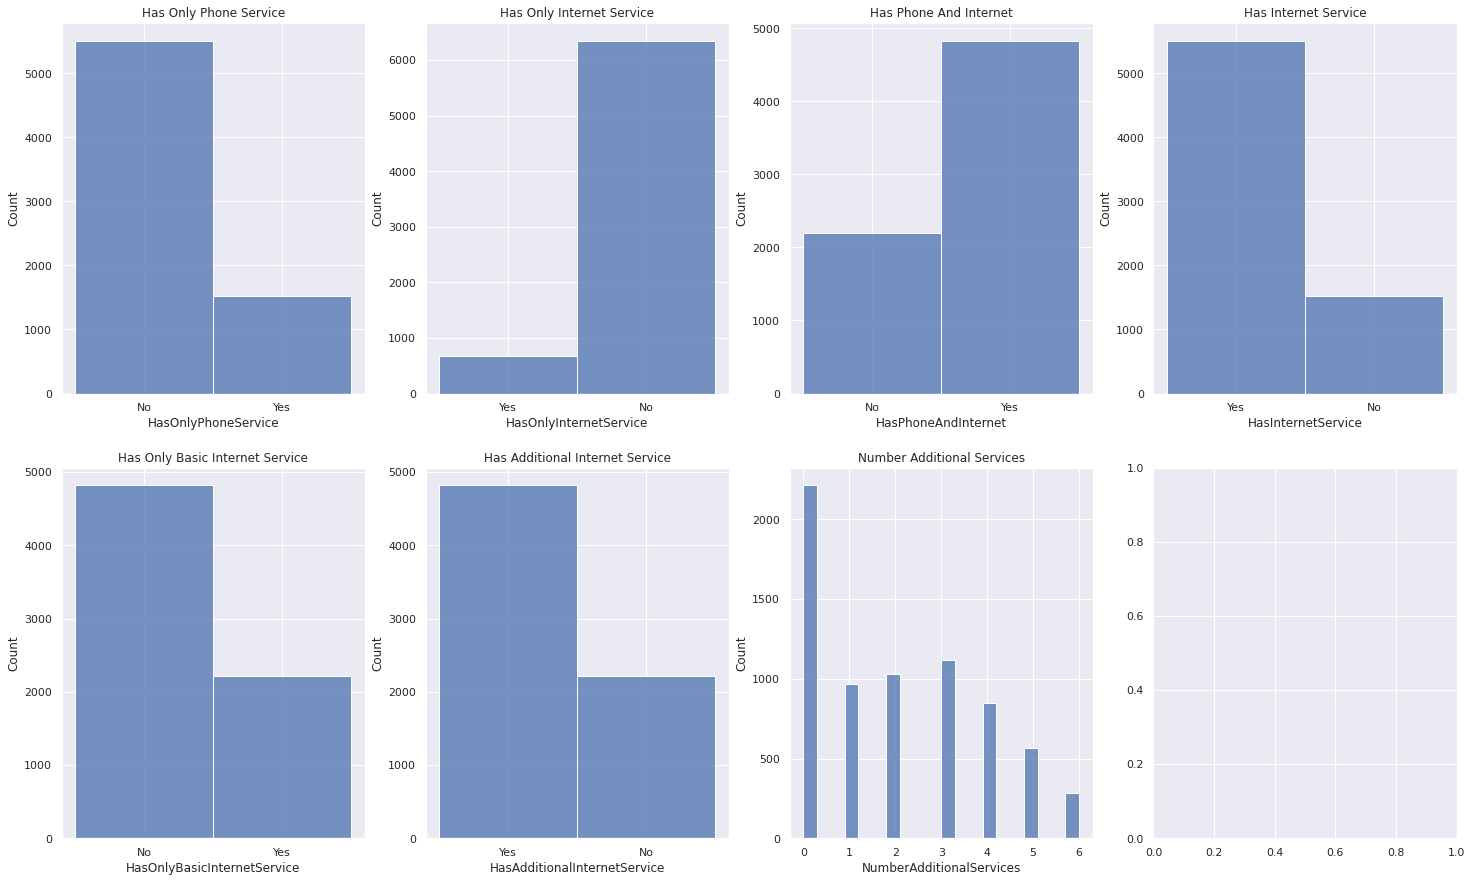

In [72]:
fig,ax = plt.subplots(2,4,figsize=(25,15))
sns.histplot(data=df, x="HasOnlyPhoneService", bins=2, ax=ax[0,0]).set_title('Has Only Phone Service')
sns.histplot(data=df, x="HasOnlyInternetService", bins=2, ax=ax[0,1]).set_title('Has Only Internet Service')
sns.histplot(data=df, x="HasPhoneAndInternet", bins=2, ax=ax[0,2]).set_title('Has Phone And Internet')
sns.histplot(data=df, x="HasInternetService", bins=2, ax=ax[0,3]).set_title('Has Internet Service')
sns.histplot(data=df, x="HasOnlyBasicInternetService", bins=2, ax=ax[1,0]).set_title('Has Only Basic Internet Service')
sns.histplot(data=df, x="HasAdditionalInternetService", bins=2, ax=ax[1,1]).set_title('Has Additional Internet Service')
sns.histplot(data=df, x="NumberAdditionalServices", ax=ax[1,2]).set_title('Number Additional Services')

Analyzing Data by New Columns

In [73]:
ServiceType=['HasOnlyPhoneService','HasOnlyInternetService','HasPhoneAndInternet','HasInternetService','HasOnlyBasicInternetService','HasAdditionalInternetService']
MeanMonthlyCharges=[df.loc[df['HasOnlyPhoneService'] == 'Yes']['MonthlyCharges'].mean(),df.loc[df['HasOnlyInternetService'] == 'Yes']['MonthlyCharges'].mean(),df.loc[df['HasPhoneAndInternet'] == 'Yes']['MonthlyCharges'].mean(),df.loc[df['HasInternetService'] == 'Yes']['MonthlyCharges'].mean(),df.loc[df['HasOnlyBasicInternetService'] == 'Yes']['MonthlyCharges'].mean(),df.loc[df['HasAdditionalInternetService'] == 'Yes']['MonthlyCharges'].mean()]
MeanTenure=[df.loc[df['HasOnlyPhoneService'] == 'Yes']['tenure'].mean(),df.loc[df['HasOnlyInternetService'] == 'Yes']['tenure'].mean(),df.loc[df['HasPhoneAndInternet'] == 'Yes']['tenure'].mean(),df.loc[df['HasInternetService'] == 'Yes']['tenure'].mean(),df.loc[df['HasOnlyBasicInternetService'] == 'Yes']['tenure'].mean(),df.loc[df['HasAdditionalInternetService'] == 'Yes']['tenure'].mean()]
NumberCustomers=[len(df.loc[df['HasOnlyPhoneService'] == 'Yes']),len(df.loc[df['HasOnlyInternetService'] == 'Yes']),len(df.loc[df['HasPhoneAndInternet'] == 'Yes']),len(df.loc[df['HasInternetService'] == 'Yes']),len(df.loc[df['HasOnlyBasicInternetService'] == 'Yes']) ,len(df.loc[df['HasAdditionalInternetService'] == 'Yes'])]

In [74]:
# Calculate % churn for customer service segments
HasOnlyPhoneServiceChurn=len(df.loc[(df['HasOnlyPhoneService'] == 'Yes') & (df['Churn'] == 'Yes')]) / len(df.loc[df['HasOnlyPhoneService'] == 'Yes'])*100
HasOnlyInternetServiceChurn=len(df.loc[(df['HasOnlyInternetService'] == 'Yes') & (df['Churn'] == 'Yes')]) / len(df.loc[df['HasOnlyInternetService'] == 'Yes'])*100
HasPhoneAndInternetChurn=len(df.loc[(df['HasPhoneAndInternet'] == 'Yes') & (df['Churn'] == 'Yes')]) / len(df.loc[df['HasPhoneAndInternet'] == 'Yes'])*100
HasInternetServiceChurn=len(df.loc[(df['HasInternetService'] == 'Yes') & (df['Churn'] == 'Yes')]) / len(df.loc[df['HasInternetService'] == 'Yes'])*100
HasOnlyBasicInternetServiceChurn=len(df.loc[(df['HasOnlyBasicInternetService'] == 'Yes') & (df['Churn'] == 'Yes')]) / len(df.loc[df['HasOnlyBasicInternetService'] == 'Yes'])*100
HasAdditionalInternetServiceChurn=len(df.loc[(df['HasAdditionalInternetService'] == 'Yes') & (df['Churn'] == 'Yes')]) / len(df.loc[df['HasAdditionalInternetService'] == 'Yes'])*100

ChurnPercentage=[HasOnlyPhoneServiceChurn,HasOnlyInternetServiceChurn,HasPhoneAndInternetChurn,HasInternetServiceChurn,HasOnlyBasicInternetServiceChurn,HasAdditionalInternetServiceChurn]

round_list_churn = [round(val,2) for val in ChurnPercentage]


In [75]:
data = {'ServiceSegment': ServiceType, 'NumberCustomers': NumberCustomers, 'AverageMonthlyCharges': MeanMonthlyCharges, 'Average Tenure': MeanTenure,'% Churn':round_list_churn }
ChargesByServiceSegment=pd.DataFrame(data)
ChargesByServiceSegment

,ServiceSegment,NumberCustomers,AverageMonthlyCharges,Average Tenure,% Churn
0,HasOnlyPhoneService,1520,21.076283,30.667763,7.43
1,HasOnlyInternetService,680,41.992500,31.830882,25.00
2,HasPhoneAndInternet,4832,81.761207,33.056705,32.82
3,HasInternetService,5512,76.855053,32.905479,31.86
4,HasOnlyBasicInternetService,2213,32.822662,24.196566,21.46
5,HasAdditionalInternetService,4819,79.482144,36.199004,28.93


**Table shows churn is not a major issue for 1,520 customers who have only phone service - % churn is low and average monthly charges are low. And this is also a different product. We should consider seperating these rows and handling them as a different problem.**

> Indented block



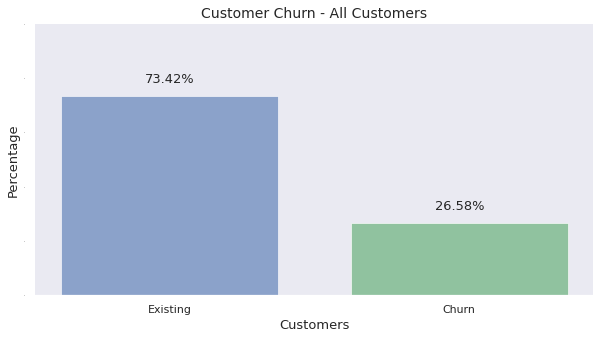

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64


In [76]:
Churn_rate = df['Churn'].value_counts(normalize=True)
Generate_bar_graph(Churn_rate.index.map({'No':'Existing','Yes':'Churn'})
                   , Churn_rate.values
                   , 'Customers'
                   , 'Percentage'
                   , 'Customer Churn - All Customers')
print(Churn_rate)

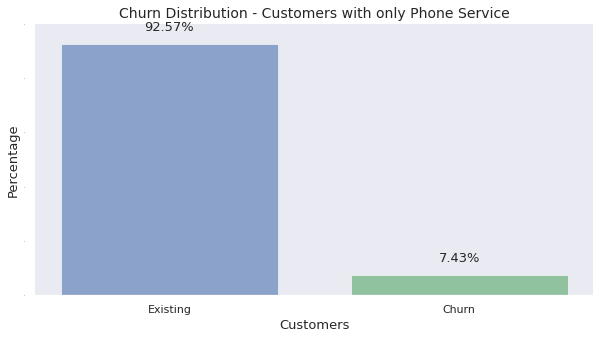

No     0.925658
Yes    0.074342
Name: Churn, dtype: float64


In [77]:
df2 = df.loc[df['HasOnlyPhoneService'] == 'Yes']
Churn_rate_Phone = df2['Churn'].value_counts(normalize=True)
#Churn_rate_Phone=df.loc['HasOnlyPhoneService'] == 'Yes']['Churn'].value_counts(normalize=True)
Generate_bar_graph(Churn_rate_Phone.index.map({'No':'Existing','Yes':'Churn'})
                   , Churn_rate_Phone.values
                   , 'Customers'
                   , 'Percentage'
                   , 'Churn Distribution - Customers with only Phone Service')
print(Churn_rate_Phone)

In [78]:
print('Number of customers with only phone service and no Internet service:')
print(len(df2))

Number of customers with only phone service and no Internet service:
1520


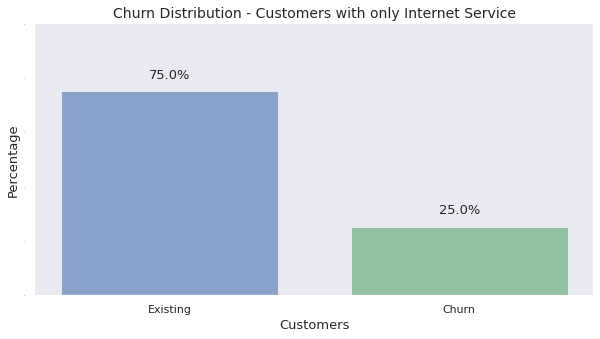

No     0.75
Yes    0.25
Name: Churn, dtype: float64


In [79]:
df3 = df.loc[df['HasOnlyInternetService'] == 'Yes']
Churn_rate_Internet = df3['Churn'].value_counts(normalize=True)
Generate_bar_graph(Churn_rate_Internet.index.map({'No':'Existing','Yes':'Churn'})
                   , Churn_rate_Internet.values
                   , 'Customers'
                   , 'Percentage'
                   , 'Churn Distribution - Customers with only Internet Service')
print(Churn_rate_Internet)

In [80]:
print('Number of customers with only Internet service and no phone service:')
print(len(df3))

Number of customers with only Internet service and no phone service:
680


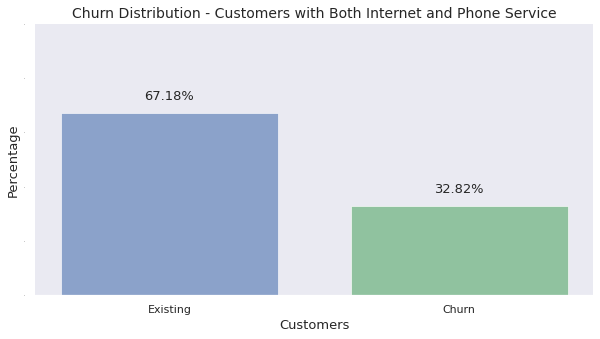

No     0.671772
Yes    0.328228
Name: Churn, dtype: float64


In [81]:
df4 = df.loc[df['HasPhoneAndInternet'] == 'Yes']
Churn_rate_Internet_Phone = df4['Churn'].value_counts(normalize=True)
Generate_bar_graph(Churn_rate_Internet_Phone.index.map({'No':'Existing','Yes':'Churn'})
                   , Churn_rate_Internet_Phone.values
                   , 'Customers'
                   , 'Percentage'
                   , 'Churn Distribution - Customers with Both Internet and Phone Service')
print(Churn_rate_Internet_Phone)

In [82]:
print('Number of customers with only Internet service and no phone service:')
print(len(df4))

Number of customers with only Internet service and no phone service:
4832


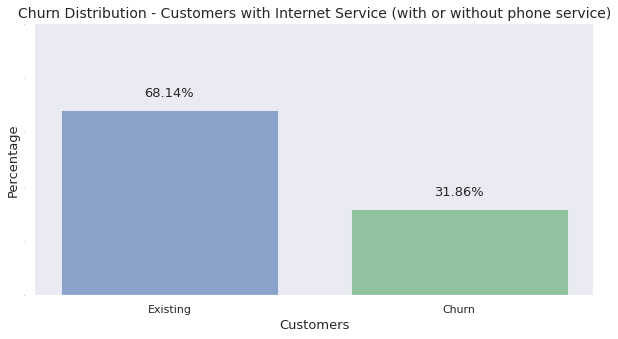

No     0.681422
Yes    0.318578
Name: Churn, dtype: float64


In [83]:
df5 = df.loc[df['HasInternetService'] == 'Yes']
Churn_rate_Internet = df5['Churn'].value_counts(normalize=True)
Generate_bar_graph(Churn_rate_Internet.index.map({'No':'Existing','Yes':'Churn'})
                   , Churn_rate_Internet.values
                   , 'Customers'
                   , 'Percentage'
                   , 'Churn Distribution - Customers with Internet Service (with or without phone service)')
print(Churn_rate_Internet)

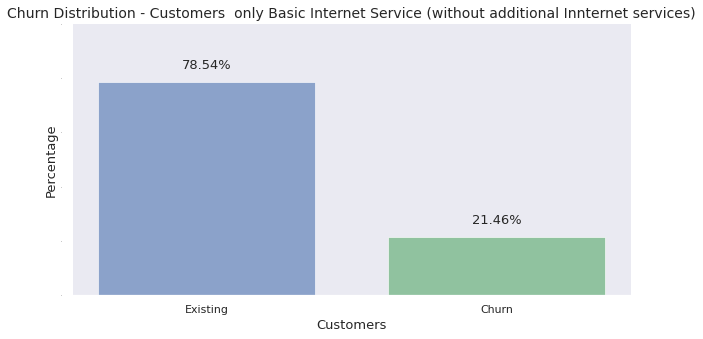

No     0.785359
Yes    0.214641
Name: Churn, dtype: float64


In [84]:
df6 = df.loc[df['HasOnlyBasicInternetService'] == 'Yes']
Churn_rate_Basic = df6['Churn'].value_counts(normalize=True)
Generate_bar_graph(Churn_rate_Basic.index.map({'No':'Existing','Yes':'Churn'})
                   , Churn_rate_Basic.values
                   , 'Customers'
                   , 'Percentage'
                   , 'Churn Distribution - Customers  only Basic Internet Service (without additional Innternet services)')
print(Churn_rate_Basic)

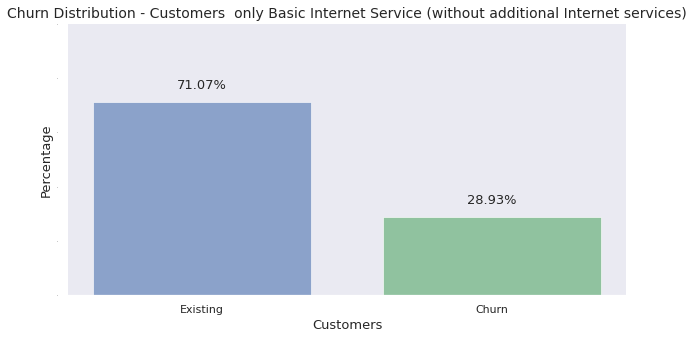

No     0.710728
Yes    0.289272
Name: Churn, dtype: float64


In [85]:
df7 = df.loc[df['HasAdditionalInternetService'] == 'Yes']
Churn_rate_add = df7['Churn'].value_counts(normalize=True)
Generate_bar_graph(Churn_rate_add.index.map({'No':'Existing','Yes':'Churn'})
                   , Churn_rate_add.values
                   , 'Customers'
                   , 'Percentage'
                   , 'Churn Distribution - Customers  only Basic Internet Service (without additional Internet services)')
print(Churn_rate_add)

# **Clustering (Unsupervised Learning)**

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   customerID                    7032 non-null   object  
 1   gender                        7032 non-null   object  
 2   SeniorCitizen                 7032 non-null   int64   
 3   Partner                       7032 non-null   object  
 4   Dependents                    7032 non-null   object  
 5   tenure                        7032 non-null   int64   
 6   TenureCategory                7032 non-null   category
 7   PhoneService                  7032 non-null   object  
 8   MultipleLines                 7032 non-null   object  
 9   InternetService               7032 non-null   object  
 10  OnlineSecurity                7032 non-null   object  
 11  OnlineBackup                  7032 non-null   object  
 12  DeviceProtection              7032 non-null   ob

Cluster Charges and Tenure

In [87]:
scaler = MinMaxScaler()
df[['MonthlyChargesScaled','tenureScaled']]=scaler.fit_transform(df[['MonthlyCharges','tenure']])

### Show Elbow curve

Text(0, 0.5, 'Inertia')

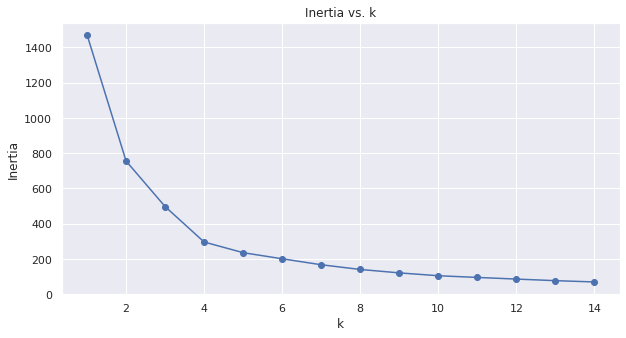

In [88]:
# k - num of clusters
def calc_inertia(k):
    model = KMeans(n_clusters=k, random_state = 42).fit(df[['MonthlyChargesScaled','tenureScaled']])
    return model.inertia_

    
x = []
y = []
for k in range(1,15):
  x.append(k)
  y.append(calc_inertia(k))
plt.plot(x,y, marker='o')
plt.title('Inertia vs. k')
plt.xlabel('k')
plt.ylabel('Inertia')

In [89]:
kmeans = KMeans(n_clusters = 4, random_state = 42).fit(df[['MonthlyChargesScaled','tenureScaled']])
df['monthly_and_tenure_cluster_labels'] = kmeans.labels_
df['monthly_and_tenure_cluster_labels'].unique()

array([3, 0, 1, 2], dtype=int32)

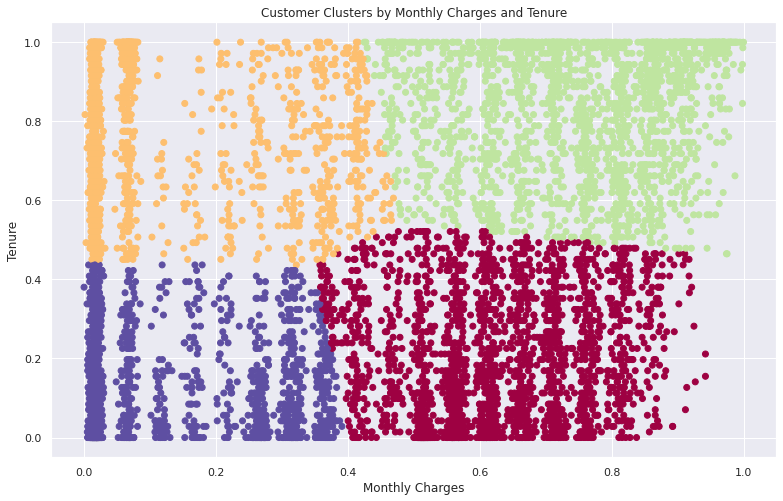

In [90]:
fig, ax = plt.subplots(figsize=(13,8))
plt.scatter( df['MonthlyChargesScaled'], df['tenureScaled'],
           c = df['monthly_and_tenure_cluster_labels'], cmap = 'Spectral')
plt.title('Customer Clusters by Monthly Charges and Tenure')
plt.xlabel('Monthly Charges')
plt.ylabel('Tenure')
plt.show()

In [91]:
df[['MonthlyChargesScaled','tenureScaled']].groupby(df['monthly_and_tenure_cluster_labels']).describe().T

monthly_and_tenure_cluster_labels            0            1            2  \
MonthlyChargesScaled count         2243.000000  1153.000000  1934.000000   
                     mean             0.626340     0.156741     0.742117   
                     std              0.126079     0.154691     0.141010   
                     min              0.357711     0.001493     0.424876   
                     25%              0.524876     0.019403     0.627488   
                     50%              0.616418     0.068657     0.758209   
                     75%              0.719403     0.317910     0.861070   
                     max              0.942289     0.469154     1.000000   
tenureScaled         count         2243.000000  1153.000000  1934.000000   
                     mean             0.198527     0.746821     0.817746   
                     std              0.157201     0.171800     0.154068   
                     min              0.000000     0.436620     0.464789   
                     25%              0.042254     0.591549     0.690141   
                     50%              0.169014     0.746479     0.845070   
                     75%              0.338028     0.915493     0.971831   
                     max              0.521127     1.000000     1.000000   

monthly_and_tenure_cluster_labels            3  
MonthlyChargesScaled count         1702.000000  
                     mean             0.138736  
                     std              0.134661  
                     min              0.000000  
                     25%              0.017910  
                     50%              0.067910  
                     75%              0.272637  
                     max              0.391045  
tenureScaled         count         1702.000000  
                     mean             0.131717  
                     std              0.128317  
                     min              0.000000  
                     25%              0.014085  
                     50%              0.098592  
                     75%              0.225352  
                     max              0.436620

In [92]:
# LCLT - low charges low tenure = 3
# LCHT - low charges high tenure = 1
# HCLT - high charges low tenure = 0
# HCHT - high charges high tenure = 2

In [93]:
cluster_distrib = df['monthly_and_tenure_cluster_labels'].value_counts()

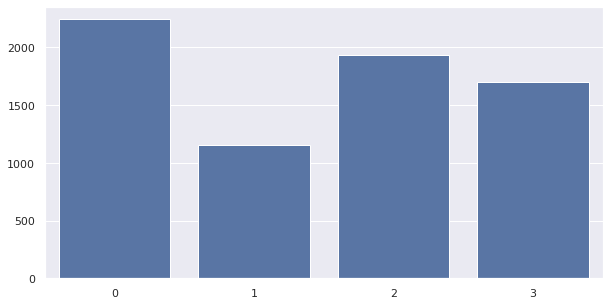

In [94]:
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b');

In [95]:
df['monthly_and_tenure_cluster_labels'] = df['monthly_and_tenure_cluster_labels'].replace([0,1,2,3],['HCLT','LCHT','HCHT','LCLT'])

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   customerID                         7032 non-null   object  
 1   gender                             7032 non-null   object  
 2   SeniorCitizen                      7032 non-null   int64   
 3   Partner                            7032 non-null   object  
 4   Dependents                         7032 non-null   object  
 5   tenure                             7032 non-null   int64   
 6   TenureCategory                     7032 non-null   category
 7   PhoneService                       7032 non-null   object  
 8   MultipleLines                      7032 non-null   object  
 9   InternetService                    7032 non-null   object  
 10  OnlineSecurity                     7032 non-null   object  
 11  OnlineBackup                       7032 non

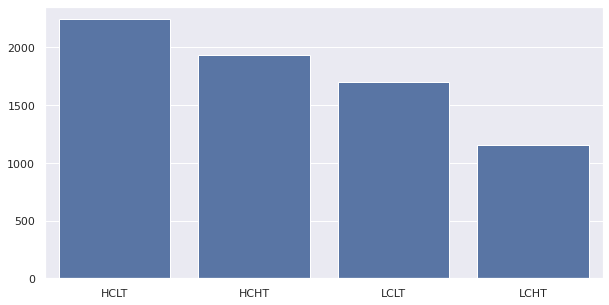

In [97]:
cluster_distrib = df['monthly_and_tenure_cluster_labels'].value_counts()
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b');

Text(0.5, 1.0, 'Segment LCLT - Churn')

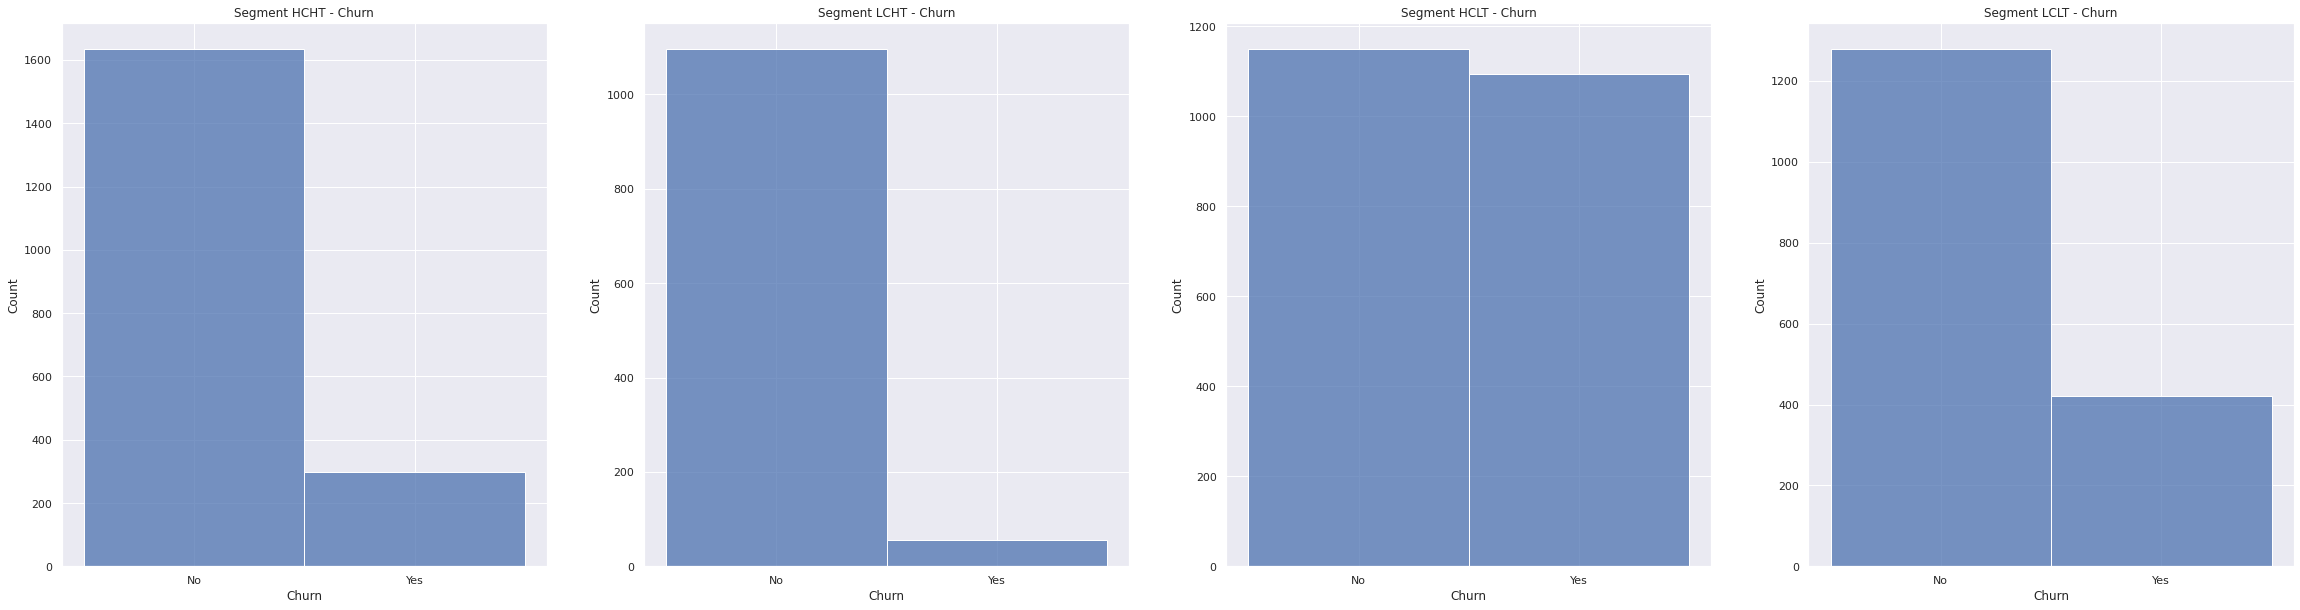

In [98]:
fig,ax = plt.subplots(1,4,figsize=(40,10))
sns.histplot(data=df.loc[df['monthly_and_tenure_cluster_labels'] =='HCHT'], x="Churn", ax=ax[0], bins=2).set_title('Segment HCHT - Churn')
sns.histplot(data=df.loc[df['monthly_and_tenure_cluster_labels'] =='LCHT'], x="Churn", ax=ax[1], bins=2).set_title('Segment LCHT - Churn')
sns.histplot(data=df.loc[df['monthly_and_tenure_cluster_labels'] =='HCLT'], x="Churn", ax=ax[2], bins=2).set_title('Segment HCLT - Churn')
sns.histplot(data=df.loc[df['monthly_and_tenure_cluster_labels'] =='LCLT'], x="Churn", ax=ax[3], bins=2).set_title('Segment LCLT - Churn')

In [99]:
CustomerSegment=['HCHT','HCLT','LCHT','LCLT']

MeanMonthlyChargesSeg=[df.loc[df['monthly_and_tenure_cluster_labels'] == 'HCHT']['MonthlyCharges'].mean(),
                       df.loc[df['monthly_and_tenure_cluster_labels'] == 'HCLT']['MonthlyCharges'].mean(),
                       df.loc[df['monthly_and_tenure_cluster_labels'] == 'LCHT']['MonthlyCharges'].mean(),
                       df.loc[df['monthly_and_tenure_cluster_labels'] == 'LCLT']['MonthlyCharges'].mean()]

MeanTenureSeg=[df.loc[df['monthly_and_tenure_cluster_labels'] == 'HCHT']['tenure'].mean(),
               df.loc[df['monthly_and_tenure_cluster_labels'] == 'HCLT']['tenure'].mean(),
               df.loc[df['monthly_and_tenure_cluster_labels'] == 'LCHT']['tenure'].mean(),
               df.loc[df['monthly_and_tenure_cluster_labels'] == 'LCLT']['tenure'].mean()]

NumberCustomersSeg=[len(df.loc[df['monthly_and_tenure_cluster_labels'] == 'HCHT']),
                    len(df.loc[df['monthly_and_tenure_cluster_labels'] == 'HCLT']),
                    len(df.loc[df['monthly_and_tenure_cluster_labels'] == 'LCHT']),
                    len(df.loc[df['monthly_and_tenure_cluster_labels'] == 'LCLT'])]

# Calculate % churn for customer service segments
HCHTChurn=len(df.loc[(df['monthly_and_tenure_cluster_labels'] == 'HCHT') & (df['Churn'] == 'Yes')]) / len(df.loc[df['monthly_and_tenure_cluster_labels'] == 'HCHT'])
HCLTChurn=len(df.loc[(df['monthly_and_tenure_cluster_labels'] == 'HCLT') & (df['Churn'] == 'Yes')]) / len(df.loc[df['monthly_and_tenure_cluster_labels'] == 'HCLT'])
LCHTChurn=len(df.loc[(df['monthly_and_tenure_cluster_labels'] == 'LCHT') & (df['Churn'] == 'Yes')]) / len(df.loc[df['monthly_and_tenure_cluster_labels'] == 'LCHT'])
LCLTChurn=len(df.loc[(df['monthly_and_tenure_cluster_labels'] == 'LCLT') & (df['Churn'] == 'Yes')]) / len(df.loc[df['monthly_and_tenure_cluster_labels'] == 'LCLT'])

SegChurnPercentage=[HCHTChurn,HCLTChurn,LCHTChurn,LCLTChurn]

RoundSegChurnPercentage_list = [round(val*100, 2) for val in SegChurnPercentage]

In [100]:
data = {'CustomerSegment': CustomerSegment, 'NumberCustomers': NumberCustomersSeg, 'AverageMonthlyCharges': MeanMonthlyChargesSeg, 'Average Tenure': MeanTenureSeg,'% Churn':RoundSegChurnPercentage_list }
ChargesByCustomerSegment=pd.DataFrame(data)
ChargesByCustomerSegment

,CustomerSegment,NumberCustomers,AverageMonthlyCharges,Average Tenure,% Churn
0,HCHT,1934,92.832756,59.059979,15.41
1,HCLT,2243,81.197147,15.095408,48.73
2,LCHT,1153,34.002515,54.024284,4.86
3,LCLT,1702,32.192920,10.351939,24.79


# **Correlation Heatmap**

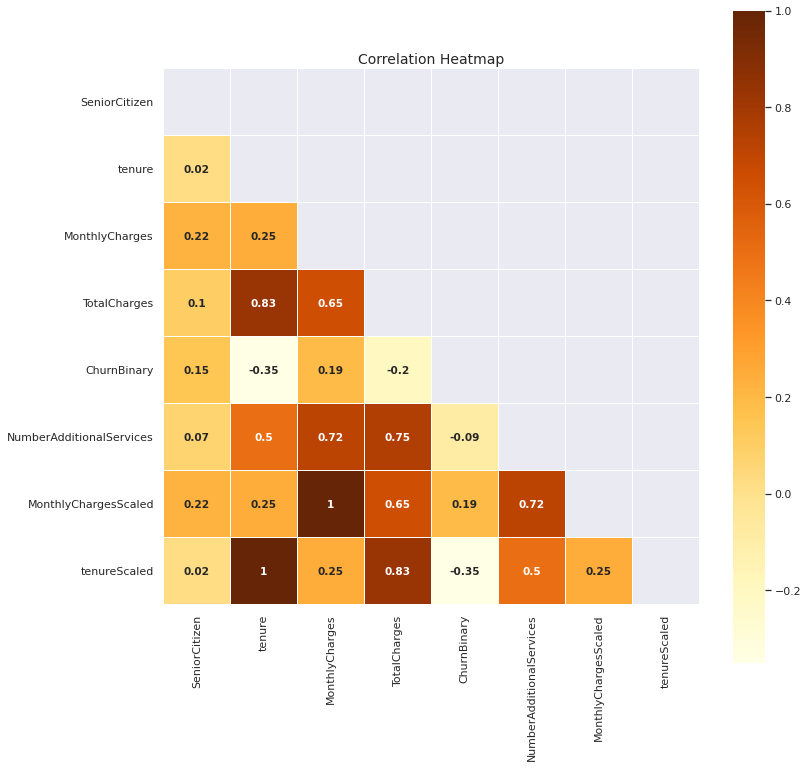

In [101]:
def Generate_heatmap_graph(corr, chart_title, mask_uppertri=False):
    """ Based on features , generate correlation matrix """
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = mask_uppertri
    fig,ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr
                , mask = mask
                , square = True
                , annot = True
                , annot_kws={'size': 10.5, 'weight' : 'bold'}
                , cmap=plt.get_cmap("YlOrBr")
                , linewidths=.1)
    plt.title(chart_title, fontsize=14)
    plt.show()


var_corr = round(df.corr(),2)
Generate_heatmap_graph(var_corr
                       ,chart_title = 'Correlation Heatmap'
                       ,mask_uppertri = True)

# **Data Preparation for modeling**

## Dropping unnecessary Features

In [102]:
# 'customerID' - has no meaning for prediction
# 'Churn' ('Yes','No') - we stay with 'ChurnBinary' (1,0)
# drop scaled features used only for clustering - 'MonthlyChargesScaled', 'tenureScaled'
df = df.drop(['customerID','Churn', 'MonthlyChargesScaled', 'tenureScaled'],axis=1)

Converting 'SeniorCitizen' - 1/0 to Yes/No

In [103]:
df.SeniorCitizen = df.SeniorCitizen.replace([1,0],['Yes','No'])

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   gender                             7032 non-null   object  
 1   SeniorCitizen                      7032 non-null   object  
 2   Partner                            7032 non-null   object  
 3   Dependents                         7032 non-null   object  
 4   tenure                             7032 non-null   int64   
 5   TenureCategory                     7032 non-null   category
 6   PhoneService                       7032 non-null   object  
 7   MultipleLines                      7032 non-null   object  
 8   InternetService                    7032 non-null   object  
 9   OnlineSecurity                     7032 non-null   object  
 10  OnlineBackup                       7032 non-null   object  
 11  DeviceProtection                   7032 non

In [105]:
for col in df:
    print(col + str(df[col].unique()))

gender['Female' 'Male']
SeniorCitizen['No' 'Yes']
Partner['Yes' 'No']
Dependents['No' 'Yes']
tenure[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
TenureCategory['New Customer', 'Medium Term Customer', 'Long Term Customer']
Categories (3, object): ['New Customer' < 'Medium Term Customer' < 'Long Term Customer']
PhoneService['No' 'Yes']
MultipleLines['No phone service' 'No' 'Yes']
InternetService['DSL' 'Fiber optic' 'No']
OnlineSecurity['No' 'Yes' 'No internet service']
OnlineBackup['Yes' 'No' 'No internet service']
DeviceProtection['No' 'Yes' 'No internet service']
TechSupport['No' 'Yes' 'No internet service']
StreamingTV['No' 'Yes' 'No internet service']
StreamingMovies['No' 'Yes' 'No internet service']
Contract['Month-to-month' 'One year' 'Two year']
PaperlessBilling['Yes' 'No']
PaymentMethod['Electronic check' 'Ma

In [106]:
#numerical variables
num_features = list(df.select_dtypes(include=['int64','float64']))
num_features.remove('ChurnBinary')

#categorical variables
cat_features = list(df.select_dtypes(include=['object','category']))

print(f'Categorical features: {cat_features}')
print(f'Numeric features: {num_features}')
print("Target: ['ChurnBinary']")

Categorical features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'TenureCategory', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyChargesCategory', 'HasInternetService', 'HasOnlyPhoneService', 'HasOnlyInternetService', 'HasPhoneAndInternet', 'HasAdditionalInternetService', 'HasOnlyBasicInternetService', 'monthly_and_tenure_cluster_labels']
Numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'NumberAdditionalServices']
Target: ['ChurnBinary']


## One-Hot Encoding

In [107]:
df = pd.get_dummies(data=df, columns=cat_features, drop_first=True)
df

,tenure,MonthlyCharges,TotalCharges,ChurnBinary,NumberAdditionalServices,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,TenureCategory_Medium Term Customer,TenureCategory_Long Term Customer,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyChargesCategory_Medium Monthly Charges,MonthlyChargesCategory_High Monthly Charges,HasInternetService_Yes,HasOnlyPhoneService_Yes,HasOnlyInternetService_Yes,HasPhoneAndInternet_Yes,HasAdditionalInternetService_Yes,HasOnlyBasicInternetService_Yes,monthly_and_tenure_cluster_labels_HCLT,monthly_and_tenure_cluster_labels_LCHT,monthly_and_tenure_cluster_labels_LCLT
0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1
1,34,56.95,1889.50,0,2,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,0
2,2,53.85,108.15,1,2,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,1
3,45,42.30,1840.75,0,3,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0
4,2,70.70,151.65,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,0,5,1,0,1,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0
7039,72,103.20,7362.90,0,4,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0,0,0,0
7040,11,29.60,346.45,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1
7041,4,74.40,306.60,1,0,1,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 45 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   tenure                                         7032 non-null   int64  
 1   MonthlyCharges                                 7032 non-null   float64
 2   TotalCharges                                   7032 non-null   float64
 3   ChurnBinary                                    7032 non-null   int64  
 4   NumberAdditionalServices                       7032 non-null   int64  
 5   gender_Male                                    7032 non-null   uint8  
 6   SeniorCitizen_Yes                              7032 non-null   uint8  
 7   Partner_Yes                                    7032 non-null   uint8  
 8   Dependents_Yes                                 7032 non-null   uint8  
 9   TenureCategory_Medium Term Customer            7032 

## Dividing the Data into X and y

In [109]:
X = df.drop(['ChurnBinary'],axis = 1)
y = df['ChurnBinary']

In [110]:
X.shape, y.shape

((7032, 44), (7032,))

## Splitting the Data to train and test

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [112]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5274, 44), (5274,), (1758, 44), (1758,))

## Optional - change one-hot encoding to Target Encoding

In [113]:
# encoder = TargetEncoder()
# X_train[cat_features]= encoder.fit_transform(X_train[cat_features], y_train)
# X_test[cat_features] = encoder.transform(X_test[cat_features])

In [114]:
X_train.head()

,tenure,MonthlyCharges,TotalCharges,NumberAdditionalServices,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,TenureCategory_Medium Term Customer,TenureCategory_Long Term Customer,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyChargesCategory_Medium Monthly Charges,MonthlyChargesCategory_High Monthly Charges,HasInternetService_Yes,HasOnlyPhoneService_Yes,HasOnlyInternetService_Yes,HasPhoneAndInternet_Yes,HasAdditionalInternetService_Yes,HasOnlyBasicInternetService_Yes,monthly_and_tenure_cluster_labels_HCLT,monthly_and_tenure_cluster_labels_LCHT,monthly_and_tenure_cluster_labels_LCLT
3166,14,48.80,664.40,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1
4333,31,90.55,2929.75,3,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,1,0,1,0,0
1927,47,107.35,5118.95,4,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0
2315,35,73.45,2661.10,3,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,0
858,66,89.00,5898.60,3,0,0,1,0,0,1,1,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0


## Scaling numeric features

Remember: we don't want to suffer from data leakage so we fit and transform the training set, while only transforming the test set

In [115]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [116]:
X_train.head()

,tenure,MonthlyCharges,TotalCharges,NumberAdditionalServices,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,TenureCategory_Medium Term Customer,TenureCategory_Long Term Customer,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyChargesCategory_Medium Monthly Charges,MonthlyChargesCategory_High Monthly Charges,HasInternetService_Yes,HasOnlyPhoneService_Yes,HasOnlyInternetService_Yes,HasPhoneAndInternet_Yes,HasAdditionalInternetService_Yes,HasOnlyBasicInternetService_Yes,monthly_and_tenure_cluster_labels_HCLT,monthly_and_tenure_cluster_labels_LCHT,monthly_and_tenure_cluster_labels_LCLT
3166,-0.748175,-0.526380,-0.712154,-0.564229,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1
4333,-0.056016,0.858262,0.290305,0.520818,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,1,0,1,0,0
1927,0.595428,1.415436,1.259067,1.063342,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0
2315,0.106845,0.291139,0.171422,0.520818,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,0
858,1.369017,0.806856,1.604076,0.520818,0,0,1,0,0,1,1,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0


## Dealing with Class Imbalance with SMOTE

In [117]:
counter = Counter(y_train)
print(counter)

Counter({0: 3863, 1: 1411})


In [118]:
print(f'Shape of X_train before SMOTE: {X_train.shape}')
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print(f'Shape of X_train after SMOTE: {X_train.shape}')

print('\nBalance of positive and negative classes (%):')
y_train.value_counts(normalize=True) * 100

Shape of X_train before SMOTE: (5274, 44)
Shape of X_train after SMOTE: (7726, 44)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: ChurnBinary, dtype: float64

In [119]:
# summarize the new class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 3863, 1: 3863})


# Traditional ML Classification Models

## Grid Search based on Random Forest Classifier (with 5-Fold cross-validation)

In [ ]:
# this param_grid takes to long to run
# rf_param_grid = {'n_estimators':[50, 100, 400, 700, 1000],
#               'max_depth':[2, 4, 10, 12, 16],
#               'criterion':['gini','entropy']} 

rf_param_grid = {'n_estimators':[100, 500, 1000],
                 'max_depth':[4, 12, 16],
                 #'min_samples_leaf': [1, 2, 4],
                 #'min_samples_split': [2, 5, 10],
                 'criterion':['gini','entropy']}

In [ ]:
grid_rf = GridSearchCV(RandomForestClassifier(random_state=random_state),
                       param_grid=rf_param_grid, verbose=1, scoring='accuracy', cv=5)

In [ ]:
grid_rf.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 12, 16],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
print("Best parameters: {}".format(grid_rf.best_params_))
print("Best score is {:.3f}".format(grid_rf.best_score_))

Best parameters: {'criterion': 'gini', 'max_depth': 16, 'n_estimators': 1000}
Best score is 0.849


In [ ]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=16, criterion='gini', random_state=random_state) 
# Note: n_estimators default is 100 (Changed from 10 to 100 in sklearn version 0.22.)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=1000, random_state=42)

In [ ]:
y_train_pred = rf_model.predict(X_train)
y_pred = rf_model.predict(X_test)

print("Train accuracy score:", accuracy_score(y_train,y_train_pred))
print("Test accuracy score:", accuracy_score(y_test, y_pred))

train_RMSE_score = (mean_squared_error(y_train, y_train_pred))**0.5
test_RMSE_score = (mean_squared_error(y_test, y_pred))**0.5

print("Train RMSE score: ", train_RMSE_score)
print("Test RMSE score: ", test_RMSE_score)


Train accuracy score: 0.9773492104581931
Test accuracy score: 0.7571103526734926
Train RMSE score:  0.15050179248702283
Test RMSE score:  0.4928383582134282


In [ ]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm,
             index=rf_model.classes_,
             columns=rf_model.classes_)

,0,1
0,1040,260
1,167,291


In [ ]:
print('Classification report: \n', classification_report(y_test,y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1300
           1       0.53      0.64      0.58       458

    accuracy                           0.76      1758
   macro avg       0.69      0.72      0.70      1758
weighted avg       0.77      0.76      0.76      1758



In [ ]:
pd.Series(rf_model.feature_importances_,
          index=X.columns).sort_values(ascending=False)

tenure                                           0.135778
TotalCharges                                     0.120547
MonthlyCharges                                   0.114302
Contract_Two year                                0.055896
NumberAdditionalServices                         0.040940
Contract_One year                                0.039312
OnlineSecurity_Yes                               0.038019
InternetService_Fiber optic                      0.037154
TechSupport_Yes                                  0.033137
monthly_and_tenure_cluster_labels_HCLT           0.029630
TenureCategory_Long Term Customer                0.025896
gender_Male                                      0.022462
Dependents_Yes                                   0.021479
PaymentMethod_Electronic check                   0.019989
Partner_Yes                                      0.019021
PaperlessBilling_Yes                             0.018233
PaymentMethod_Credit card (automatic)            0.017074
OnlineBackup_Y

### SHAP values

SHAP (SHapley Additive exPlanations) is a **unified approach to explain the output of any machine learning model.** SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.

* https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

* https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

In [ ]:
import shap
shap_values = shap.TreeExplainer(rf_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

ModuleNotFoundError: ignored

In [ ]:
shap.summary_plot(shap_values[1], X_train)

# fig.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

## Grid Search based on XGBoost Classifier (with 5-Fold cross-validation) 

In [ ]:
xgb_param_grid = {'n_estimators': range(60,220,40), 
                 'max_depth': range(2,10),
                 'learning_rate': [0.1, 0.01, 0.05]}

In [ ]:
estimator = XGBClassifier(
    # booster = 'gblinear',
    objective='binary:logistic',
    nthreads=4, 
    seed = random_state
)

In [ ]:
grid_xgb = GridSearchCV(estimator, param_grid=xgb_param_grid, verbose=1, scoring='accuracy', n_jobs = 10, cv=5)

In [ ]:
grid_xgb.fit(X_train,y_train)

In [ ]:
print("Best parameters: {}".format(grid_xgb.best_params_))
print("Best score is {:.3f}".format(grid_xgb.best_score_))

In [ ]:
xgb_model = XGBClassifier(n_estimators=180, max_depth=9, learning_rate=0.05, random_state=random_state) # booster = 'gblinear' 
# Note: n_estimators default is 100 (Changed from 10 to 100 in sklearn version 0.22.)

xgb_model.fit(X_train, y_train)

In [ ]:
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)

print("Train accuracy score:", accuracy_score(y_train,y_train_pred))
print("Test accuracy score:", accuracy_score(y_test, y_pred))

train_RMSE_score = (mean_squared_error(y_train, y_train_pred))**0.5
test_RMSE_score = (mean_squared_error(y_test, y_pred))**0.5

print("Train RMSE score: ", train_RMSE_score)
print("Test RMSE score: ", test_RMSE_score)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm,
             index=xgb_model.classes_,
             columns=xgb_model.classes_)

In [ ]:
print('Classification report: \n', classification_report(y_test,y_pred))

In [ ]:
pd.Series(xgb_model.feature_importances_,
          index=X.columns).sort_values(ascending=False)

# Neural Network Model

In [ ]:
X.shape[1]

In [ ]:
# Defining NN sequential model,
# setting the parameters and layers of the deep neural network which will be used for training the data.
model = keras.Sequential([
    # input layer
    keras.layers.Dense(X.shape[1], input_shape=(X.shape[1],), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(10,activation = 'relu'),
    # we use sigmoid for binary output
    # output layer
    keras.layers.Dense(1, activation='sigmoid')
]
)

In [ ]:
# Compiling the Model. The compile defines the loss function, the optimizer, and the metrics which we have to give into parameters.
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
# Printing Model summary
model.summary()

In [ ]:
# Fitting the Model to training data
my_history = model.fit(X_train, y_train, epochs=100)

In [ ]:
(pd.DataFrame(my_history.history)**0.5).plot()

In [ ]:
# Evaluating the Model on test data
model.evaluate(X_test, y_test)

In [ ]:
# Predicting the Churn values

# As above we are performing scaling on the data,
# that’s why our predicted values are scaled so we have to unscale it into normal form for this we write the following program.

# creating a list of predicted variables, when the scaling values are greater than 0.5 then it will be considered as 1,
# otherwise it will be considered as 0. We store these values into the list.

y_pred = model.predict(X_test)
print(y_pred)
# unscaling the ypred values 
y_pred_list = []
for i in y_pred:
    if i>0.5:
        y_pred_list.append(1)
    else:
        y_pred_list.append(0)
print(y_pred_list)

In [ ]:
# At the conclusion we have to differentiate original and predicted values together, 
# so we find that our model predicted true or false.
# For that, we combine original values and predicted values together into a dataframe.

# making dataframe for comparing the orignal and predict values
data_dict = {'orignal_churn': y_test, 'predicted_churn': y_pred_list}
df_check = pd.DataFrame(data_dict)
df_check.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred_list)
pd.DataFrame(cm,
             index=xgb_model.classes_,
             columns=xgb_model.classes_)

In [ ]:
# checking for performance metrices
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1300
           1       0.49      0.61      0.54       458

    accuracy                           0.73      1758
   macro avg       0.67      0.69      0.68      1758
weighted avg       0.76      0.73      0.74      1758



# **SHAP values**

SHAP (SHapley Additive exPlanations) is a **unified approach to explain the output of any machine learning model.** SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.

* https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

* https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

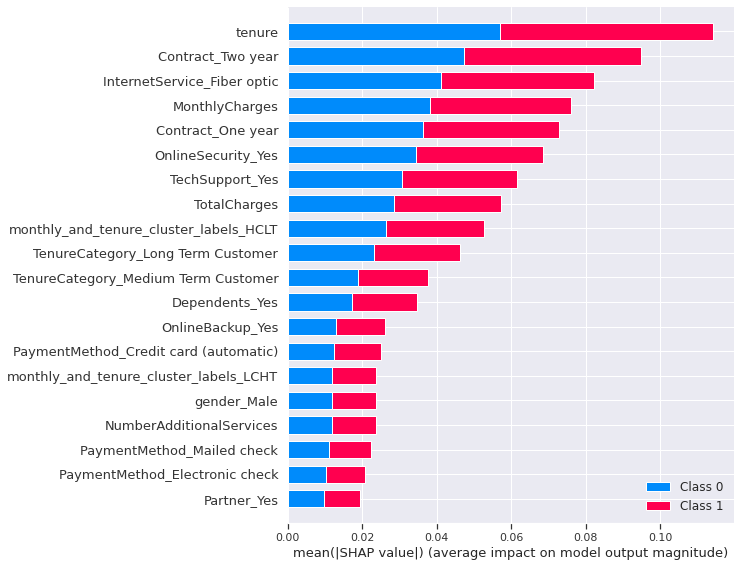

In [ ]:
import shap
shap_values = shap.TreeExplainer(rf_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

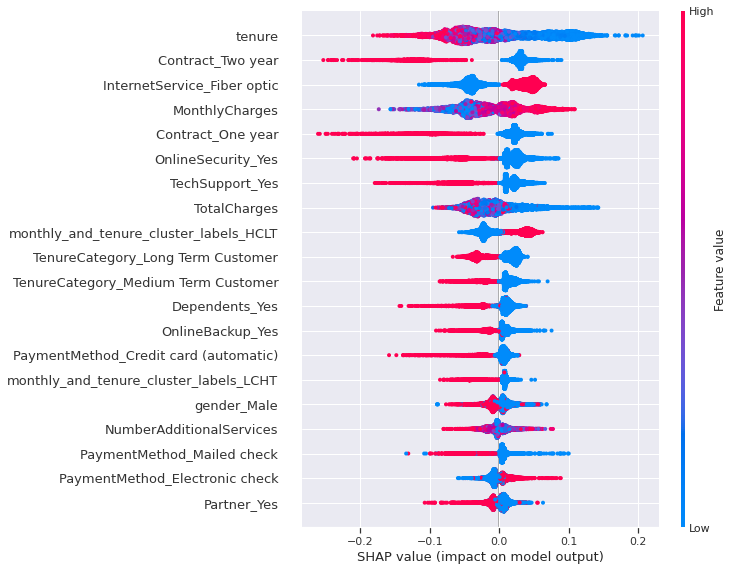

In [ ]:
shap.summary_plot(shap_values[1], X_train)

# fig.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

# Autokeras

In [ ]:
!pip install autokeras

In [120]:
import autokeras as ak

In [122]:
clf = ak.StructuredDataClassifier()
#clf = ak.StructuredDataClassifier(overwrite=True, max_trials=3)

In [123]:
my_history = clf.fit(X_train, y_train)
#As a quick demo, we set epochs to 10.
#clf.fit(x_train, y_train, epochs=10)

y_pred = clf.predict(X_test)

Trial 100 Complete [00h 00m 19s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 02h 07m 51s
INFO:tensorflow:Oracle triggered exit
242/242 [==============================] - 1s 3ms/step - loss: 0.3286 - accuracy: 0.8434
INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
55/55 [==============================] - 0s 2ms/step


In [124]:
print(clf.evaluate(X_test, y_test))

55/55 [==============================] - 0s 2ms/step - loss: 7.8203 - accuracy: 0.2605
[7.820271015167236, 0.26052331924438477]


In [125]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 44)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               5760      
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33    

In [ ]:
#(pd.DataFrame(my_history.history)**0.5).plot()